## Provided CSV

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


In [6]:
import importlib
import outliers
importlib.reload(outliers)
dir(outliers)

['LinearRegression',
 'Path',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'detect_outliers_iqr',
 'detect_outliers_zscore',
 'mean_absolute_error',
 'np',
 'pd',
 'plt',
 'r2_score',
 'winsorize_series']

In [14]:
from outliers import detect_outliers_iqr, detect_outliers_zscore
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[1]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.060870
outlier_z      0.043478
dtype: float64

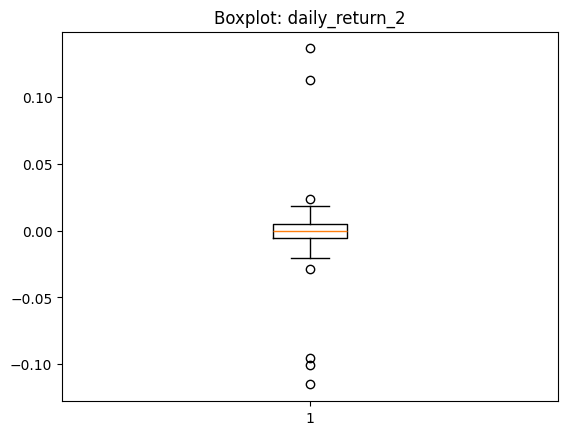

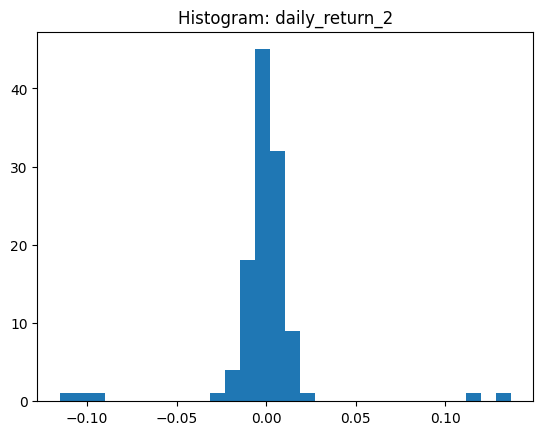

In [15]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

np.random.seed(17)
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

In [16]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr
mean,-0.000668,-0.000098
median,-0.000174,-0.000173
std,0.025068,0.007744


In [23]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

No 'x' column; skip regression or engineer features.


## Synthetic Fallback

In [24]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


In [25]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.005
outlier_z      0.005
dtype: float64

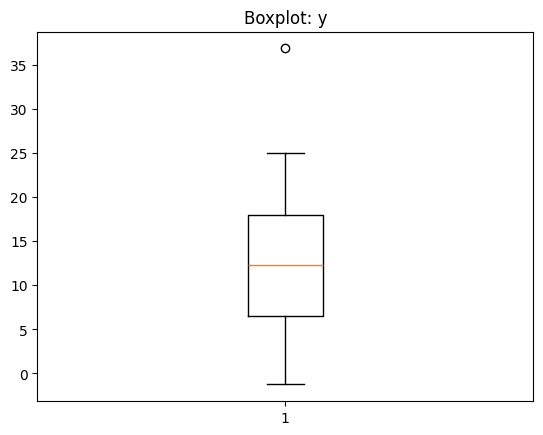

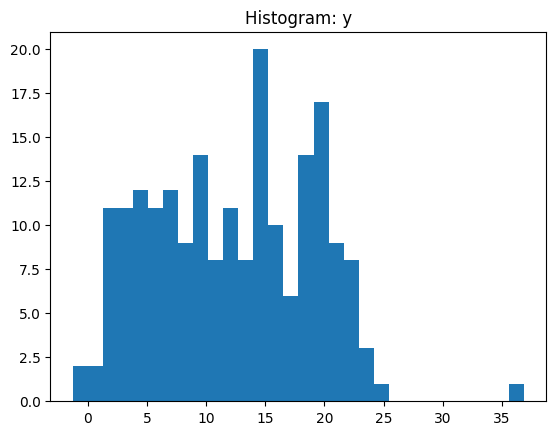

In [26]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

In [27]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr
mean,12.171936,12.047851
median,12.349663,12.285113
std,6.761378,6.546157


In [29]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    print(results)
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

                 slope  intercept        r2       mae
all           2.169679   1.323542  0.871082  1.200432
filtered_iqr  2.136650   1.397242  0.900777  1.118809


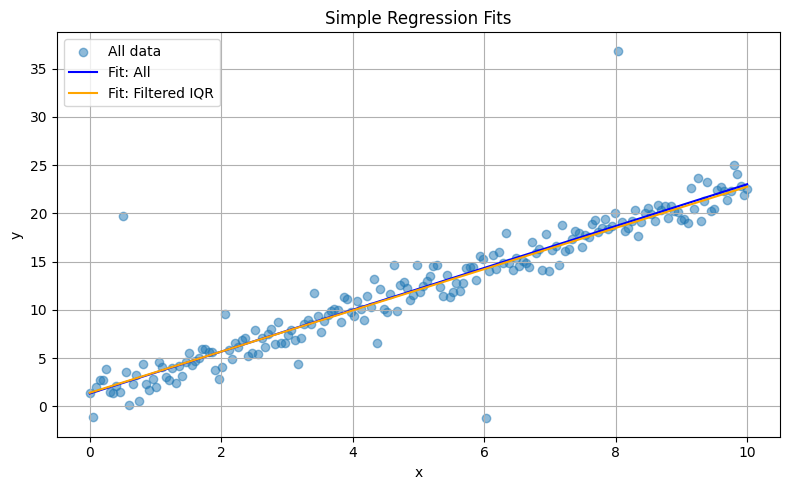

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_line = np.linspace(df['x'].min(), df['x'].max(), 100).reshape(-1, 1)

def line(slope, intercept):
    return slope * x_line[:, 0] + intercept

s_all = results.loc['all', 'slope']
i_all = results.loc['all', 'intercept']
s_flt = results.loc['filtered_iqr', 'slope']
i_flt = results.loc['filtered_iqr', 'intercept']

plt.figure(figsize=(8, 5))

plt.scatter(df['x'], df[target_col], alpha=0.5, label='All data')

plt.plot(x_line, line(s_all, i_all), label='Fit: All', color='blue')
plt.plot(x_line, line(s_flt, i_flt), label='Fit: Filtered IQR', color='orange')

plt.title("Simple Regression Fits")
plt.xlabel("x")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Reflection

### Which method(s) and thresholds I chose and why:
- I used two common methods to detect outliers: the IQR method and the Z-score method.

- For the IQR method, I applied the classical threshold of 1.5 × IQR to identify values that are far below or above the interquartile range.

- For the Z-score method, I used a threshold of 3.0, which is standard for identifying values more than 3 standard deviations from the mean.

### Assumptions behind your choices:

- The IQR method assumes the central 50% of the data represents a “normal” range and that outliers lie significantly outside this range.

- The Z-score method assumes that the data is approximately normally distributed, which may not hold in real-world cases with skewed distributions or heavy tails.

- Linear regression assumes that outliers are not informative and may distort the estimation of slope and intercept.

### Observed impacts on results:

- After removing outliers detected by the IQR method, the regression line became more stable, and the slope and intercept changed.

- The MAE (mean absolute error) decreased, and the R² score improved slightly, showing better model fit without the influence of extreme values.

- Summary statistics (mean, median, std) also shifted, highlighting how sensitive these metrics are to extreme observations.

### Risks if assumptions are wrong:

- If the removed values are not true outliers but represent valid extreme cases, the model may become biased and fail to generalize.

- If the distribution is skewed and we use Z-score, we risk misclassifying valid values as outliers due to distorted standard deviation.

- Over-filtering based on these assumptions could lead to loss of information and underestimation of variability.